# Data Challenge: Football Red Card and Race

Determine whether dark-skinned football players receive penalties at a rate higher than light-skinned players.  

This is a task that was part of a study on analysis methods [1].

[1] Silberzahn, R., E. Uhlmann, D. Martin, P. Anselmi, F. Aust, E. Awtrey, S. Bahník et al. "Many analysts, one dataset: Making transparent how variations in analytical choices affect results https://osf.io/gvm2z." (2016).

https://colab.research.google.com/drive/1srw_HFWQ2SMgmWIawucXfusGzrj1_U0q#scrollTo=c99EvWo1s9-x

Documentation for dataset: https://osf.io/9yh4x/

## Pavel Brodskiy, Gary Houk, Sophie Chen

## Our Investigation

1. Use EDA to clean data and manage correlated variables (weight / height)
2. Find a rate of red card aggregated by each player.
3. Model the rate using regression
4. Try a Mixed Effect model to attempt to account for referee-specific bias


### Hypotheses
-  Skin tone does affect the rate of red cards

## Findings
- **Result #1 for Regression:** Linear regression on data grouped by player indicates no significant (p= 0.204) effect of skin color on rate on the rate of red cards per game
- **Result #2 for Mixed Effect Model**  Inconclusive.

## Recommendation for football as a sport
- Don't aggregate your data before handing it to a data scientist - I swear we can handle that part if we need to.


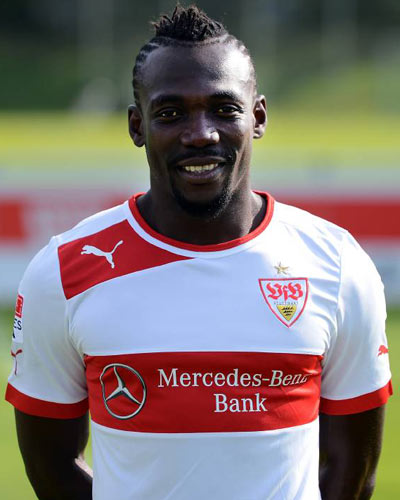

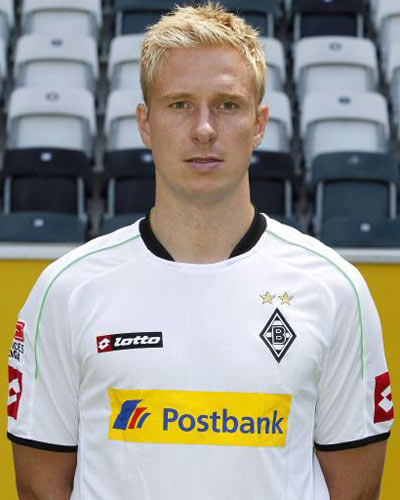

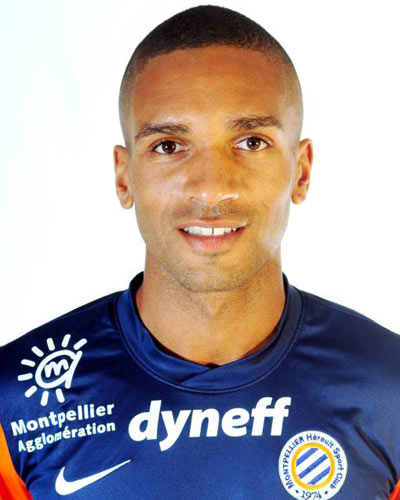

In [2]:
from IPython.display import Image, display
display(Image('Pics/static.weltsport.net-22642.jpg'))
display(Image('Pics/static.weltsport.net-2119.jpg'))
display(Image('Pics/static.weltsport.net-52333.jpg'))


In [3]:
import seaborn as sns
from pandas import Series,DataFrame
import pandas as pd
import matplotlib as mpl
import numpy as np
import random as rnd

import matplotlib.pyplot as plt
import altair as alt
alt.renderers.enable('notebook')
alt.data_transformers.enable('json')
print(alt.renderers.active)

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.manifold import TSNE

from scipy import sparse
import io


mpl.rcParams['figure.dpi'] = 150

notebook


In [4]:
# from vega_datasets import data
## basics of altair
# iris = data.iris()
# alt.Chart(iris).mark_point().encode(
#     x='petalLength',
#     y='petalWidth',
#     color='species'
# )

# Import data

In [5]:
dtype = {
    'playerShort'   : 'category',
    'player'        : 'category',
    'club'          : 'category',
    'leagueCountry' : 'category',
    'birthday'      : 'str',
    'height'        : 'float',
    'weight'        : 'float',
    'position'      : 'category',
    'games'         : 'int',
    'victories'     : 'int',
    'ties'          : 'int',
    'defeats'       : 'int',
    'goals'         : 'int',
    'yellowCards'   : 'int',
    'yellowReds'    : 'int',
    'redCards'      : 'int',
    'photoID'       : 'str',
    'rater1'        : 'float',
    'rater2'        : 'float',
    'refNum'        : 'category',
    'refCountry'    : 'category',
    'Alpha_3'       : 'category',
    'meanIAT'       : 'float',
    'nIAT'          : 'float',
    'seIAT'         : 'float',
    'meanExp'       : 'float',
    'nExp'          : 'float',
    'seExp'         : 'float'
}

In [6]:

pd.set_option('display.max_columns', None)
raw_data = pd.read_csv('redcard.csv', dtype=dtype, parse_dates=['birthday'])


In [8]:
raw_data.head(10)

,playerShort,player,club,leagueCountry,birthday,height,weight,position,games,victories,ties,defeats,goals,yellowCards,yellowReds,redCards,photoID,rater1,rater2,refNum,refCountry,Alpha_3,meanIAT,nIAT,seIAT,meanExp,nExp,seExp
0,lucas-wilchez,Lucas Wilchez,Real Zaragoza,Spain,1983-08-31,177.0,72.0,Attacking Midfielder,1,0,0,1,0,0,0,0,95212.jpg,0.25,0.50,1,1,GRC,0.326391,712.0,0.000564,0.396000,750.0,0.002696
1,john-utaka,John Utaka,Montpellier HSC,France,1982-08-01,179.0,82.0,Right Winger,1,0,0,1,0,1,0,0,1663.jpg,0.75,0.75,2,2,ZMB,0.203375,40.0,0.010875,-0.204082,49.0,0.061504
2,abdon-prats,Abdón Prats,RCD Mallorca,Spain,1992-12-17,181.0,79.0,NaN,1,0,1,0,0,1,0,0,NaN,NaN,NaN,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002
3,pablo-mari,Pablo Marí,RCD Mallorca,Spain,1993-08-31,191.0,87.0,Center Back,1,1,0,0,0,0,0,0,NaN,NaN,NaN,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002
4,ruben-pena,Rubén Peña,Real Valladolid,Spain,1991-07-18,172.0,70.0,Right Midfielder,1,1,0,0,0,0,0,0,NaN,NaN,NaN,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002
5,aaron-hughes,Aaron Hughes,Fulham FC,England,1979-08-11,182.0,71.0,Center Back,1,0,0,1,0,0,0,0,3868.jpg,0.25,0.00,4,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752
6,aleksandar-kolarov,Aleksandar Kolarov,Manchester City,England,1985-10-11,187.0,80.0,Left Fullback,1,1,0,0,0,0,0,0,47704.jpg,0.00,0.25,4,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752
7,alexander-tettey,Alexander Tettey,Norwich City,England,1986-04-04,180.0,68.0,Defensive Midfielder,1,0,0,1,0,0,0,0,22356.jpg,1.00,1.00,4,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752
8,anders-lindegaard,Anders Lindegaard,Manchester United,England,1984-04-13,193.0,80.0,Goalkeeper,1,0,1,0,0,0,0,0,16528.jpg,0.25,0.25,4,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752
9,andreas-beck,Andreas Beck,1899 Hoffenheim,Germany,1987-03-13,180.0,70.0,Right Fullback,1,1,0,0,0,0,0,0,36499.jpg,0.00,0.00,4,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752


In [9]:
[len(raw_data[['playerShort','refNum']]), len(raw_data[['playerShort','refNum']].drop_duplicates())]

[146028, 146028]

In [10]:
data = DataFrame({
    'red_cards_per_game' : (raw_data['yellowReds']+raw_data['redCards'])/raw_data['games'],
    'skin_color'         : (raw_data['rater1'] + raw_data['rater2']) / 2,
    'height'             : raw_data['height'],
    'weight'             : raw_data['weight'],
    'age'                : (pd.to_datetime('2013') - raw_data['birthday']) / pd.Timedelta(days=365.25),
    'position'           : raw_data['position'],
    'meanIAT'            : raw_data['meanIAT'],
    'meanExp'            : raw_data['meanExp'],
    'club'               : raw_data['club'],
    'refNum'             : raw_data['refNum'],
    'games'              : raw_data['games'],
})

data.dropna(inplace=True)

data.head(10)

,red_cards_per_game,skin_color,height,weight,age,position,meanIAT,meanExp,club,refNum,games
0,0.0,0.375,177.0,72.0,29.338809,Attacking Midfielder,0.326391,0.396000,Real Zaragoza,1,1
1,0.0,0.750,179.0,82.0,30.420260,Right Winger,0.203375,-0.204082,Montpellier HSC,2,1
5,0.0,0.125,182.0,71.0,33.393566,Center Back,0.325185,0.538462,Fulham FC,4,1
6,0.0,0.125,187.0,80.0,27.225188,Left Fullback,0.325185,0.538462,Manchester City,4,1
7,0.0,1.000,180.0,68.0,26.746064,Defensive Midfielder,0.325185,0.538462,Norwich City,4,1
8,0.0,0.250,193.0,80.0,28.720055,Goalkeeper,0.325185,0.538462,Manchester United,4,1
9,0.0,0.000,180.0,70.0,25.806982,Right Fullback,0.325185,0.538462,1899 Hoffenheim,4,1
10,0.0,0.000,177.0,74.0,28.933607,Right Fullback,0.325185,0.538462,Real Valladolid,4,2
11,0.0,0.500,181.0,74.0,26.655715,Left Winger,0.325185,0.538462,Fulham FC,4,1
12,0.0,0.000,187.0,80.0,24.840520,Center Back,0.325185,0.538462,FC Schalke 04,4,1


Simple data frame plots

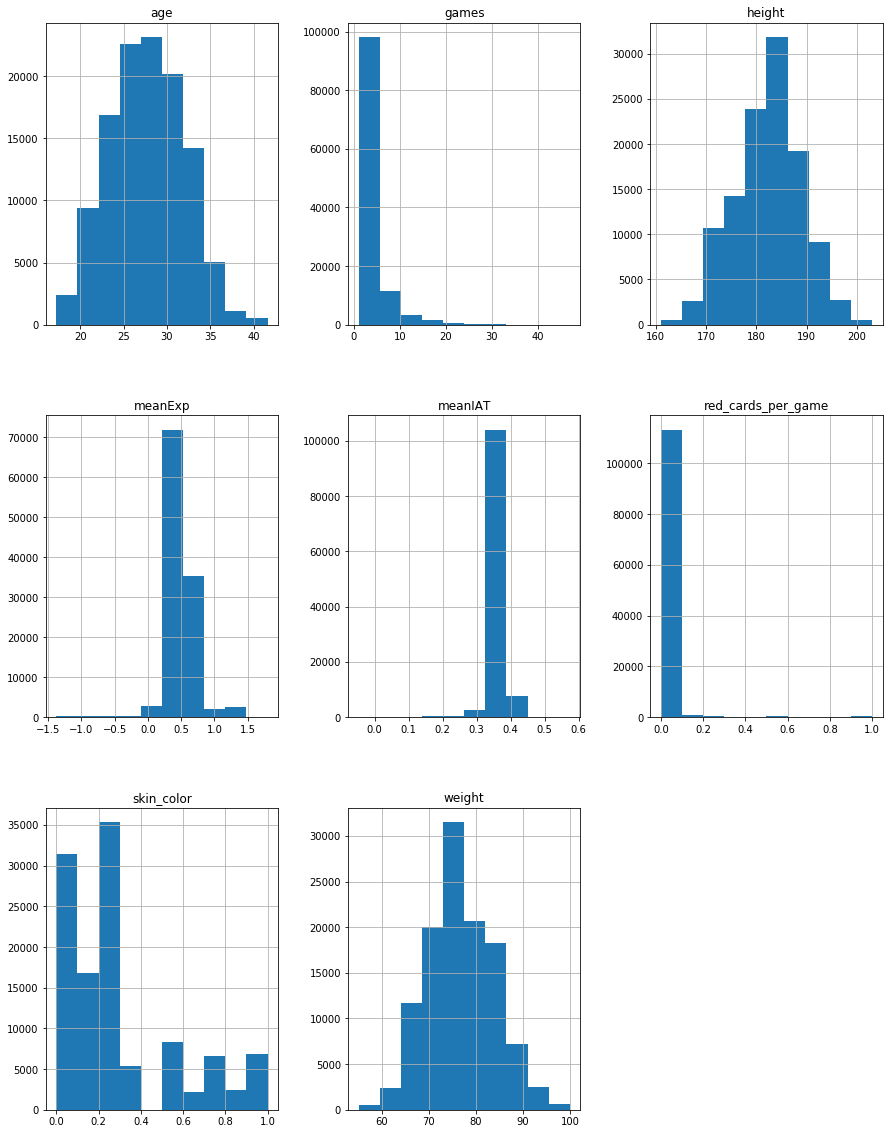

In [39]:
tmp_df = data.copy(deep=True)
blub=tmp_df.hist(figsize=(15,20))


/home/topquirk67/anaconda3/envs/insight/lib/python3.7/site-packages/seaborn/categorical.py:3692: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/home/topquirk67/anaconda3/envs/insight/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


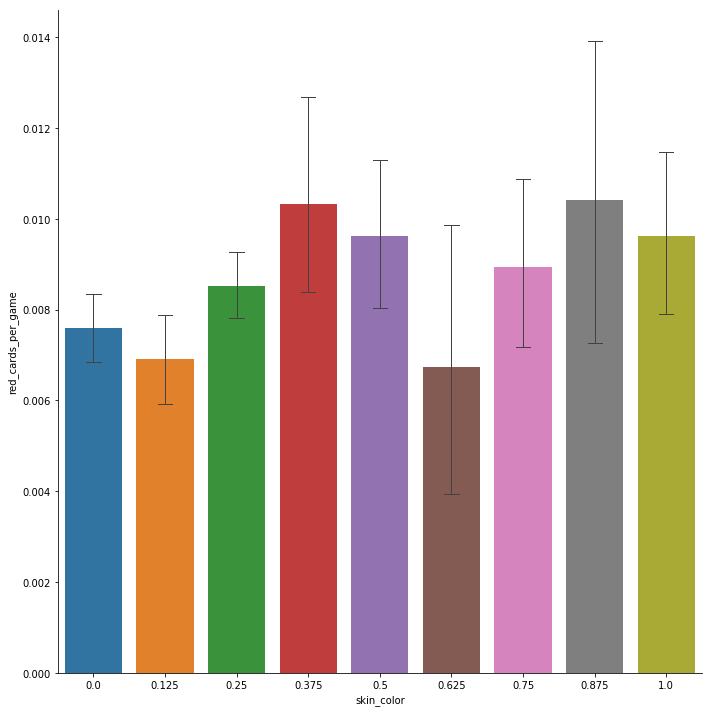

In [42]:

sns.catplot(data=tmp_df, y='red_cards_per_game', x='skin_color', kind='bar', errwidth=1, capsize=0.2, n_boot=1000, ci=95, size=10)


/home/topquirk67/anaconda3/envs/insight/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 <a list of 12 Text xticklabel objects>)

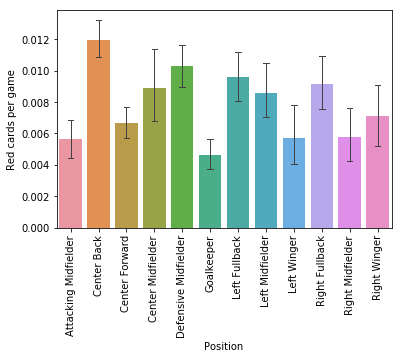

In [53]:
sns.barplot(data=tmp_df, x='position', y='red_cards_per_game', errwidth=1, capsize=0.2, n_boot=1000, ci=95)

plt.xlabel('Position')
plt.ylabel('Red cards per game')
plt.xticks(rotation='vertical')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f6ca1fc7860>,
      dtype=object)

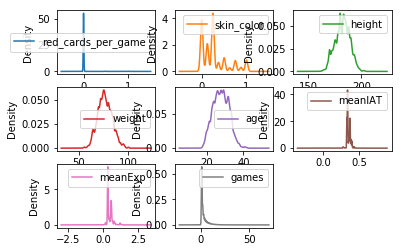

In [55]:
data.plot(kind='density', subplots=True, layout=(3,3), sharex = False)

In [56]:
raw_data[raw_data['playerShort']=='aleksandar-kolarov'].head()

,playerShort,player,club,leagueCountry,birthday,height,weight,position,games,victories,ties,defeats,goals,yellowCards,yellowReds,redCards,photoID,rater1,rater2,refNum,refCountry,Alpha_3,meanIAT,nIAT,seIAT,meanExp,nExp,seExp
6,aleksandar-kolarov,Aleksandar Kolarov,Manchester City,England,1985-10-11,187.0,80.0,Left Fullback,1,1,0,0,0,0,0,0,47704.jpg,0.0,0.25,4,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752
344,aleksandar-kolarov,Aleksandar Kolarov,Manchester City,England,1985-10-11,187.0,80.0,Left Fullback,1,0,0,1,0,0,0,0,47704.jpg,0.0,0.25,20,17,OMN,0.343632,72.0,0.007075,0.368421,76.0,0.026651
2322,aleksandar-kolarov,Aleksandar Kolarov,Manchester City,England,1985-10-11,187.0,80.0,Left Fullback,2,1,1,0,0,1,0,0,47704.jpg,0.0,0.25,88,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002
4015,aleksandar-kolarov,Aleksandar Kolarov,Manchester City,England,1985-10-11,187.0,80.0,Left Fullback,1,1,0,0,0,1,0,0,47704.jpg,0.0,0.25,113,52,RUS,0.398174,526.0,0.000809,1.212727,550.0,0.004521
5039,aleksandar-kolarov,Aleksandar Kolarov,Manchester City,England,1985-10-11,187.0,80.0,Left Fullback,2,0,1,1,0,0,0,0,47704.jpg,0.0,0.25,131,27,ROU,0.385082,537.0,0.000756,0.859431,562.0,0.003620


In [57]:
df_raw_agg = raw_data.groupby(['playerShort']).agg(['sum','mean'])
df_raw_agg = df_raw_agg.reset_index()
df_raw_agg.head()

playerShort   height          weight       games            \
                               sum   mean      sum  mean   sum      mean   
0            aaron-hughes  30212.0  182.0  11786.0  71.0   654  3.939759   
1              aaron-hunt  18117.0  183.0   7227.0  73.0   336  3.393939   
2            aaron-lennon  16665.0  165.0   6363.0  63.0   412  4.079208   
3            aaron-ramsey  18512.0  178.0   7904.0  76.0   260  2.500000   
4  abdelhamid-el-kaoutari   6660.0  180.0   2701.0  73.0   124  3.351351   

  victories           ties           defeats           goals            \
        sum      mean  sum      mean     sum      mean   sum      mean   
0       247  1.487952  179  1.078313     228  1.373494     9  0.054217   
1       141  1.424242   73  0.737374     122  1.232323    62  0.626263   
2       200  1.980198   97  0.960396     115  1.138614    31  0.306931   
3       150  1.442308   42  0.403846      68  0.653846    39  0.375000   
4        41  1.108108   40  1.081081      43  1.162162     1  0.027027   

  yellowCards           yellowReds           redCards           rater1        \
          sum      mean        sum      mean      sum      mean    sum  mean   
0          19  0.114458          0  0.000000        0  0.000000  41.50  0.25   
1          42  0.424242          0  0.000000        1  0.010101   0.00  0.00   
2          11  0.108911          0  0.000000        0  0.000000  25.25  0.25   
3          31  0.298077          0  0.000000        1  0.009615   0.00  0.00   
4           8  0.216216          4  0.108108        2  0.054054   9.25  0.25   

  rater2          meanIAT                 nIAT                   seIAT  \
     sum  mean        sum      mean        sum          mean       sum   
0   0.00  0.00  57.512216  0.346459  3271886.0  19710.156627  0.108188   
1  24.75  0.25  34.533016  0.348818  2584325.0  26104.292929  0.021653   
2  25.25  0.25  34.935186  0.345893  2144721.0  21234.861386  0.037077   
3   0.00  0.00  36.069415  0.346821  3981726.0  38285.826923  0.346742   
4   9.25  0.25  12.269183  0.331600   104797.0   2832.351351  0.055051   

               meanExp                 nExp                   seExp            
       mean        sum      mean        sum          mean       sum      mean  
0  0.000652  82.099423  0.494575  3425788.0  20637.277108  0.674798  0.004065  
1  0.000219  44.472801  0.449220  2659581.0  26864.454545  0.098278  0.000993  
2  0.000367  49.639661  0.491482  2246113.0  22238.742574  0.205244  0.002032  
3  0.003334  53.528110  0.514693  4130878.0  39719.980769  1.406334  0.013522  
4  0.001488  12.416728  0.335587   109292.0   2953.837838  0.195960  0.005296

In [58]:
df_raw_agg = raw_data.groupby(['playerShort','height','weight','birthday','position','club','rater1','rater2']).agg(['sum','mean'])
df_raw_agg = df_raw_agg.reset_index()
df_raw_agg.head()

df_agg = pd.DataFrame({
    'red_cards_per_game' : (df_raw_agg['redCards']['sum']+df_raw_agg['yellowCards']['sum']) / df_raw_agg['games']['sum'],
    'skin_color'         : (df_raw_agg['rater1'] + df_raw_agg['rater2']) / 2,
    'height'             : df_raw_agg['height'],
    'weight'             : df_raw_agg['weight'],
    'age'                : (pd.to_datetime('2013') - df_raw_agg['birthday']) / pd.Timedelta(days=365.25),
    'position'           : df_raw_agg['position'],
    'club'               : df_raw_agg['club'],
    'goals_per_game'     : df_raw_agg['goals']['sum'] / df_raw_agg['games']['sum'],
    'victory_rate'       : (df_raw_agg['victories']['sum'] + 0.5*df_raw_agg['ties']['sum']) / df_raw_agg['games']['sum'],
    'meanIAT'            : df_raw_agg['meanIAT']['mean'],
    'meanExp'            : df_raw_agg['meanExp']['mean'],
    'games'              : df_raw_agg['games']['sum'],
    'playerShort'        : df_raw_agg['playerShort'],
})

df_agg.head()

,red_cards_per_game,skin_color,height,weight,age,position,club,goals_per_game,victory_rate,meanIAT,meanExp,games,playerShort
0,0.029052,0.125,182.0,71.0,33.393566,Center Back,Fulham FC,0.013761,0.514526,0.346459,0.494575,654,aaron-hughes
1,0.127976,0.125,183.0,73.0,26.732375,Attacking Midfielder,Werder Bremen,0.184524,0.528274,0.348818,0.449220,336,aaron-hunt
2,0.026699,0.250,165.0,63.0,25.713895,Right Midfielder,Tottenham Hotspur,0.075243,0.603155,0.345893,0.491482,412,aaron-lennon
3,0.123077,0.000,178.0,76.0,22.017796,Center Midfielder,Arsenal FC,0.150000,0.657692,0.346821,0.514693,260,aaron-ramsey
4,0.080645,0.250,180.0,73.0,22.795346,Center Back,Montpellier HSC,0.008065,0.491935,0.331600,0.335587,124,abdelhamid-el-kaoutari


/home/topquirk67/anaconda3/envs/insight/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


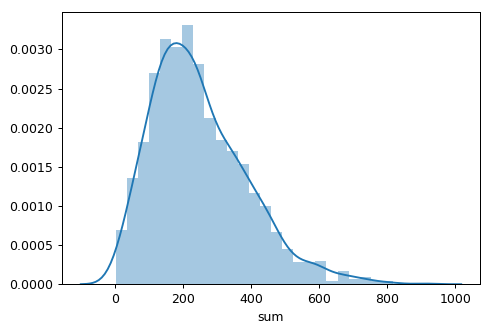

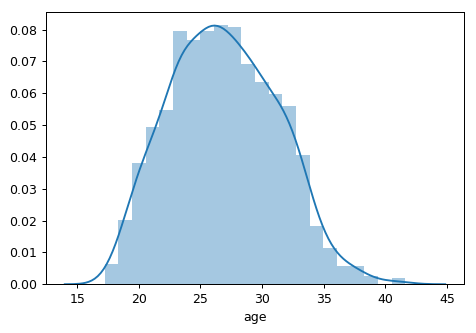

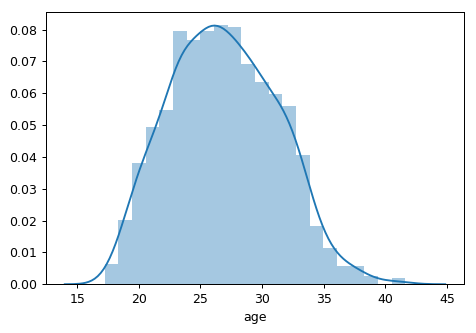

In [59]:
mpl.rcParams['figure.dpi'] = 90
sns.distplot(df_raw_agg['games']['sum'])
plt.show()

sns.distplot(df_agg['age'])
plt.show()
sns.distplot(df_agg['age'])
plt.show()

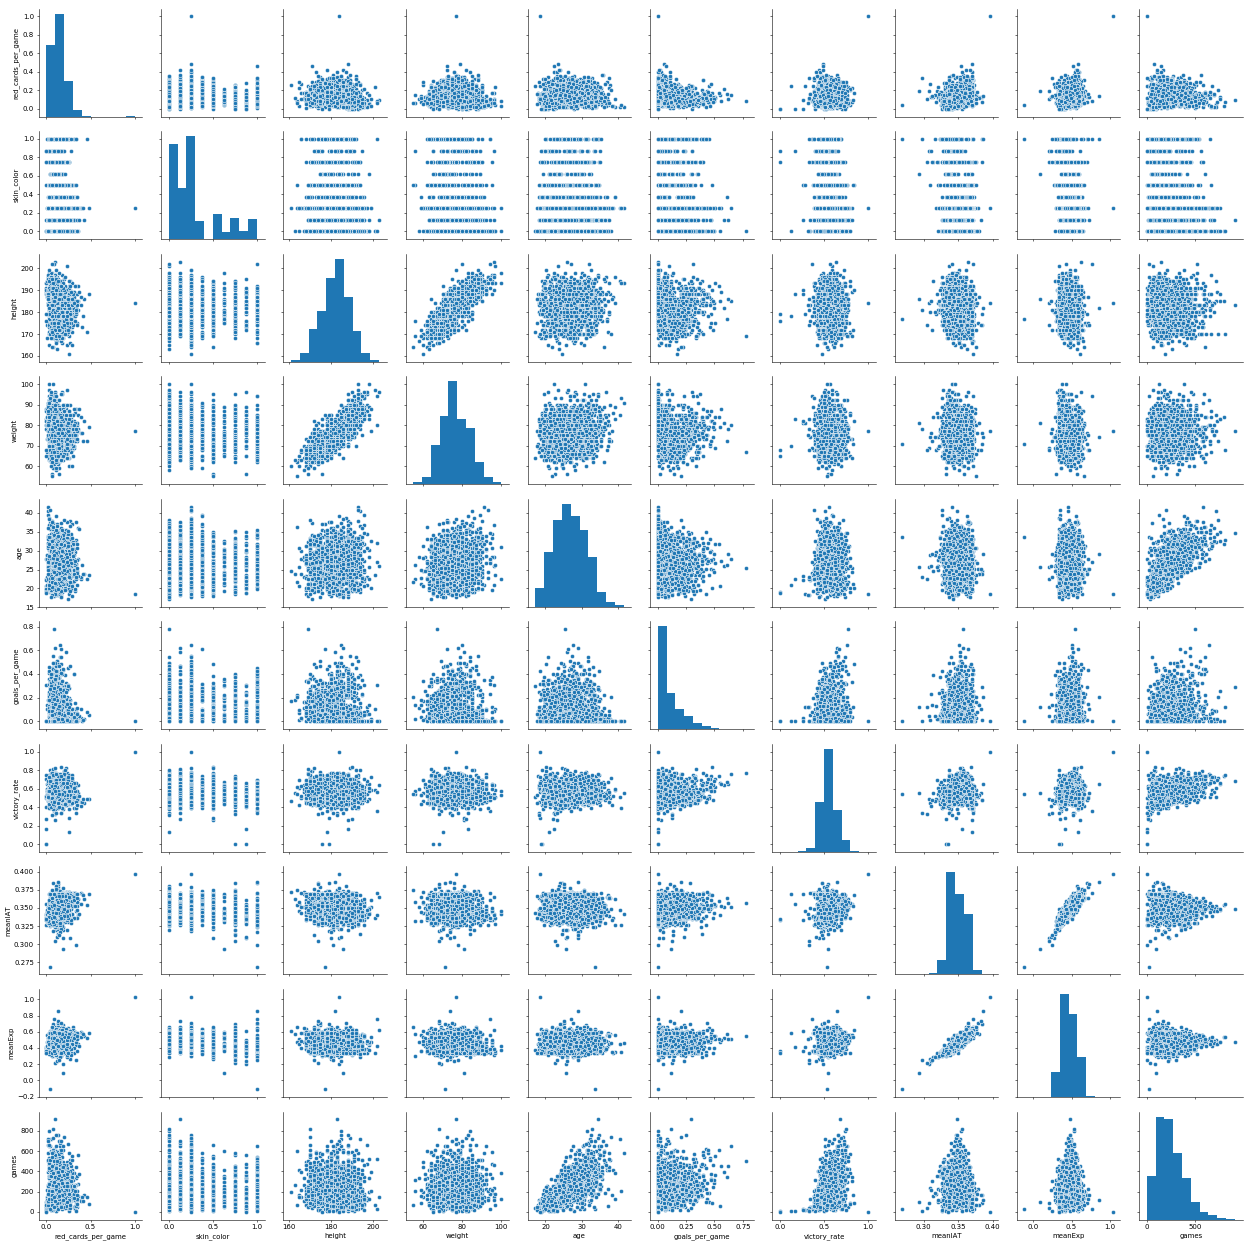

In [60]:
mpl.rcParams['figure.dpi'] = 50
sns.pairplot(df_agg)

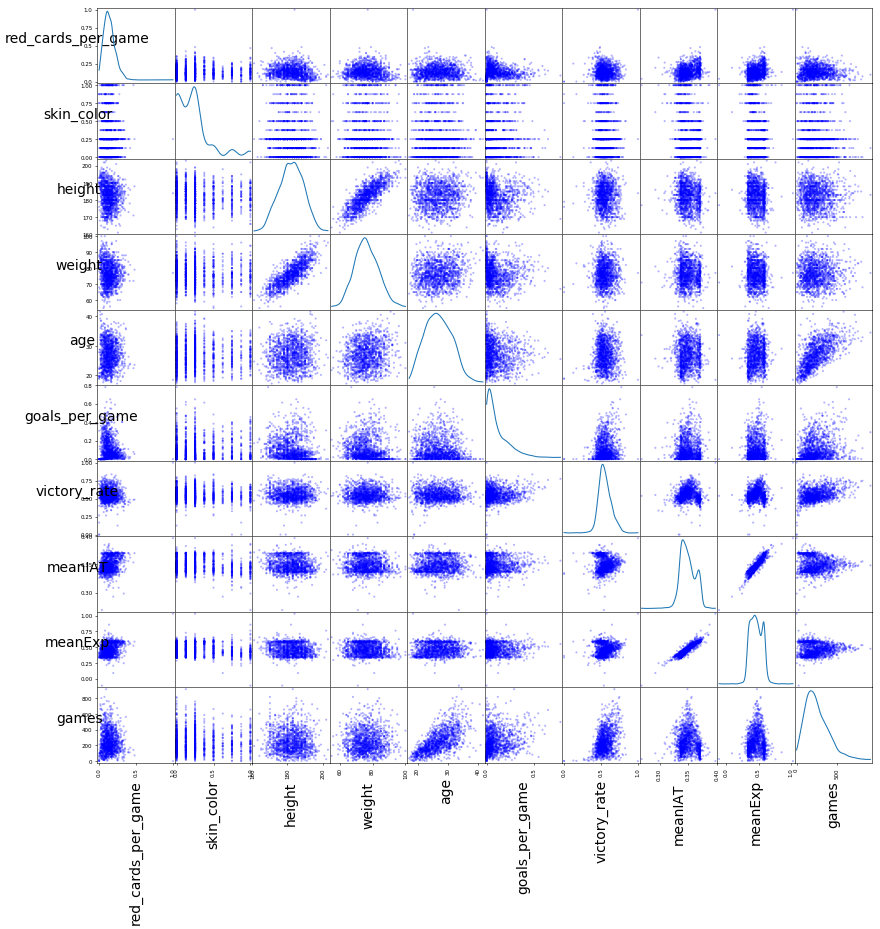

In [69]:
# Another way to do the pairs plot using matplotlib

scatter_matrix = pd.plotting.scatter_matrix(
    df_agg,
    color='b',
    alpha = 0.3,
    figsize  = [20, 20],
    marker   = ".",
    #s        = 1.0,   # [point prominance]
    diagonal = "kde"
)

for ax in scatter_matrix.ravel():
    ax.set_xlabel(ax.get_xlabel(), fontsize = 20, rotation = 90)
    ax.set_ylabel(ax.get_ylabel(), fontsize = 20, rotation = 0)

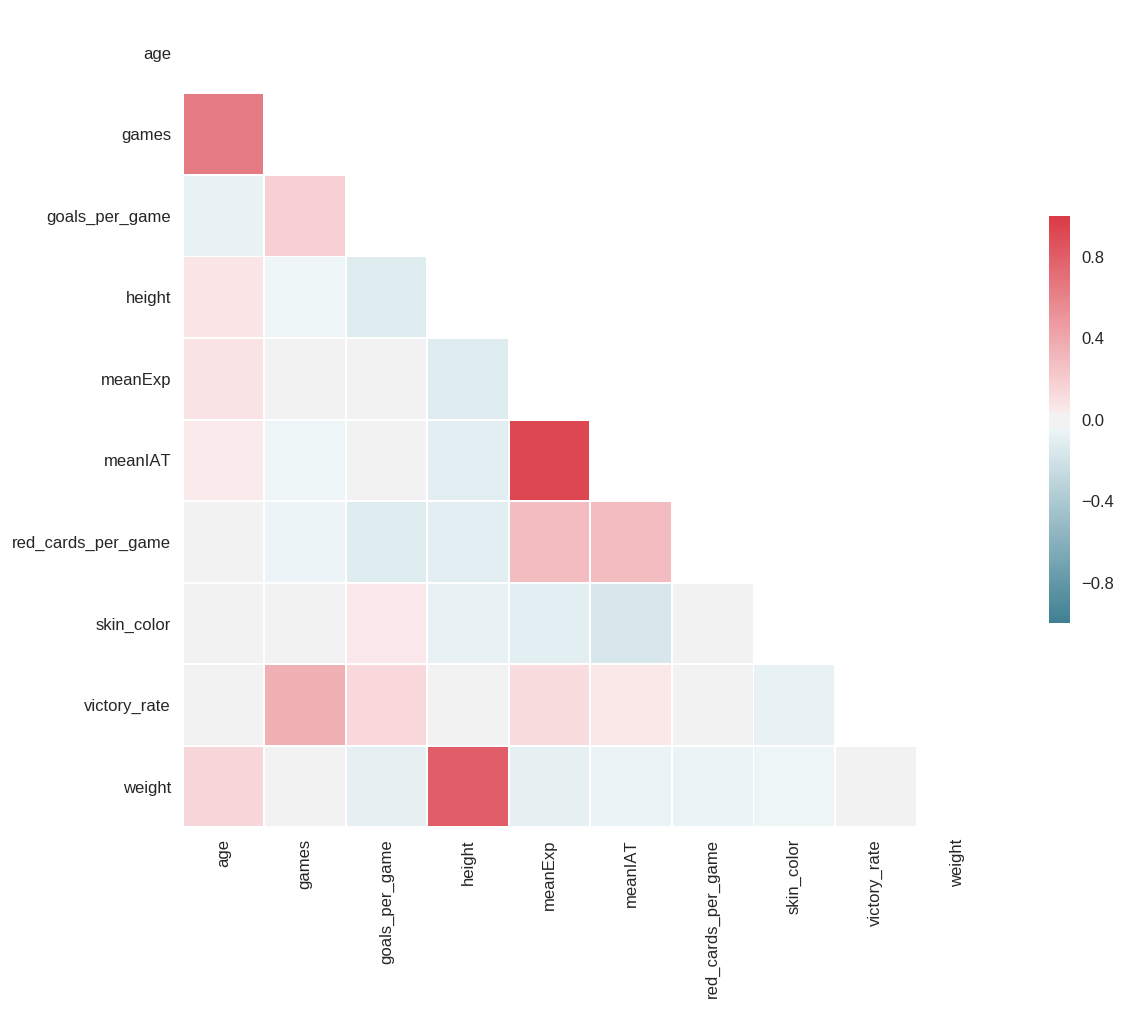

In [68]:
mpl.rcParams['figure.dpi'] = 120
sns.set(style="white")
corr = df_agg.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [69]:
df_agg = df_agg[df_agg['games'] > 5]
df_agg

,age,club,games,goals_per_game,height,meanExp,meanIAT,playerShort,position,red_cards_per_game,skin_color,victory_rate,weight
0,33.393566,Fulham FC,654,0.013761,182.0,0.494575,0.346459,aaron-hughes,Center Back,0.029052,0.125,0.514526,71.0
1,26.732375,Werder Bremen,336,0.184524,183.0,0.449220,0.348818,aaron-hunt,Attacking Midfielder,0.127976,0.125,0.528274,73.0
2,25.713895,Tottenham Hotspur,412,0.075243,165.0,0.491482,0.345893,aaron-lennon,Right Midfielder,0.026699,0.250,0.603155,63.0
3,22.017796,Arsenal FC,260,0.150000,178.0,0.514693,0.346821,aaron-ramsey,Center Midfielder,0.123077,0.000,0.657692,76.0
4,22.795346,Montpellier HSC,124,0.008065,180.0,0.335587,0.331600,abdelhamid-el-kaoutari,Center Back,0.080645,0.250,0.491935,73.0
5,24.958248,Girondins Bordeaux,97,0.030928,180.0,0.296562,0.320079,abdou-traore_2,Right Midfielder,0.113402,0.750,0.541237,74.0
6,20.758385,Stade Rennes,24,0.000000,189.0,0.400818,0.341625,abdoulaye-diallo_2,Goalkeeper,0.000000,0.875,0.500000,80.0
8,22.787132,Stade Brest,121,0.024793,180.0,0.429630,0.348178,abdoulwhaid-sissoko,Defensive Midfielder,0.190083,1.000,0.384298,68.0
9,18.899384,SpVgg Greuther Fürth,50,0.000000,179.0,0.361068,0.342072,abdul-rahman-baba,Left Fullback,0.080000,0.875,0.420000,70.0
10,20.139630,Manchester City,36,0.000000,180.0,0.536408,0.354566,abdul-razak,Center Midfielder,0.055556,1.000,0.555556,78.0


In [70]:
data_encoded = df_agg.copy(deep=True)
data_encoded = data_encoded.loc[:, data_encoded.columns != 'club']

data_encoded = pd.get_dummies(data_encoded, drop_first=True)
data_encoded.head(5)

age  games  goals_per_game  height   meanExp   meanIAT  \
0  33.393566    654        0.013761   182.0  0.494575  0.346459   
1  26.732375    336        0.184524   183.0  0.449220  0.348818   
2  25.713895    412        0.075243   165.0  0.491482  0.345893   
3  22.017796    260        0.150000   178.0  0.514693  0.346821   
4  22.795346    124        0.008065   180.0  0.335587  0.331600   

   red_cards_per_game  skin_color  victory_rate  weight  \
0            0.029052       0.125      0.514526    71.0   
1            0.127976       0.125      0.528274    73.0   
2            0.026699       0.250      0.603155    63.0   
3            0.123077       0.000      0.657692    76.0   
4            0.080645       0.250      0.491935    73.0   

   playerShort_aaron-hunt  playerShort_aaron-lennon  playerShort_aaron-ramsey  \
0                       0                         0                         0   
1                       1                         0                         0   
2                       0                         1                         0   
3                       0                         0                         1   
4                       0                         0                         0   

   playerShort_abdelhamid-el-kaoutari  playerShort_abdon-prats  \
0                                   0                        0   
1                                   0                        0   
2                                   0                        0   
3                                   0                        0   
4                                   1                        0   

   playerShort_abdou-dampha  playerShort_abdou-traore_2  \
0                         0                           0   
1                         0                           0   
2                         0                           0   
3                         0                           0   
4                         0                           0   

   playerShort_abdoul-camara  playerShort_abdoulaye-diallo_2  \
0                          0                               0   
1                          0                               0   
2                          0                               0   
3                          0                               0   
4                          0                               0   

   playerShort_abdoulaye-diallo_3  playerShort_abdoulaye-keita_2  \
0                               0                              0   
1                               0                              0   
2                               0                              0   
3                               0                              0   
4                               0                              0   

   playerShort_abdoulaye-sane  playerShort_abdoulwhaid-sissoko  \
0                           0                                0   
1                           0                                0   
2                           0                                0   
3                           0                                0   
4                           0                                0   

   playerShort_abdul-rahman-baba  playerShort_abdul-razak  \
0                              0                        0   
1                              0                        0   
2                              0                        0   
3                              0                        0   
4                              0                        0   

   playerShort_abel-aguilar  playerShort_abel-khaled  \
0                         0                        0   
1                         0                        0   
2                         0                        0   
3                         0                        0   
4                         0                        0   

   playerShort_abelaziz-barrada  playerShort_abou-diaby  \
0                             0                       0   

## Result #1 for Regression Model


In [71]:
import statsmodels.api as sm

data_encoded = df_agg.copy(deep=True)
data_encoded = data_encoded.loc[:, data_encoded.columns != 'club']
data_encoded = data_encoded.loc[:, data_encoded.columns != 'playerShort']
data_encoded = data_encoded.loc[:, data_encoded.columns != 'weight']
data_encoded = data_encoded.loc[:, data_encoded.columns != 'games']
data_encoded = data_encoded.loc[:, data_encoded.columns != 'meanIAT']
data_encoded = data_encoded.loc[:, data_encoded.columns != 'meanExp']
data_encoded = pd.get_dummies(data_encoded)

target = 'red_cards_per_game'

y = data_encoded[target].values
predictors = data_encoded.loc[:, data_encoded.columns != target].columns.values
X = data_encoded.loc[:, predictors].values

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10)

mod = sm.OLS(y, sm.add_constant(X))

res = mod.fit()

predictors_with_constant = predictors.tolist()
predictors_with_constant.insert(0, 'constant')

print(res.summary(yname=target, xname=predictors_with_constant))

/usr/local/lib/python3.6/dist-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


                            OLS Regression Results                            
Dep. Variable:     red_cards_per_game   R-squared:                       0.312
Model:                            OLS   Adj. R-squared:                  0.304
Method:                 Least Squares   F-statistic:                     39.49
Date:                Thu, 01 Nov 2018   Prob (F-statistic):          3.21e-101
Time:                        22:48:34   Log-Likelihood:                 1917.6
No. Observations:                1413   AIC:                            -3801.
Df Residuals:                    1396   BIC:                            -3712.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
constant      

In [72]:
import statsmodels.api as sm

data_encoded = df_agg.copy(deep=True)
data_encoded = data_encoded.loc[:, data_encoded.columns != 'club']
data_encoded = data_encoded.loc[:, data_encoded.columns != 'playerShort']
data_encoded = data_encoded.loc[:, data_encoded.columns != 'weight']
data_encoded = data_encoded.loc[:, data_encoded.columns != 'games']
data_encoded = data_encoded.loc[:, data_encoded.columns != 'meanIAT']
#data_encoded = data_encoded.loc[:, data_encoded.columns != 'meanExp']
data_encoded = pd.get_dummies(data_encoded)

target = 'red_cards_per_game'

y = data_encoded[target].values
predictors = data_encoded.loc[:, data_encoded.columns != target].columns.values
X = data_encoded.loc[:, predictors].values

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10)

mod = sm.OLS(y, sm.add_constant(X))

res = mod.fit()

predictors_with_constant = predictors.tolist()
predictors_with_constant.insert(0, 'constant')

print(res.summary(yname=target, xname=predictors_with_constant))

                            OLS Regression Results                            
Dep. Variable:     red_cards_per_game   R-squared:                       0.374
Model:                            OLS   Adj. R-squared:                  0.366
Method:                 Least Squares   F-statistic:                     49.01
Date:                Thu, 01 Nov 2018   Prob (F-statistic):          1.38e-128
Time:                        22:48:35   Log-Likelihood:                 1984.7
No. Observations:                1413   AIC:                            -3933.
Df Residuals:                    1395   BIC:                            -3839.
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
constant      

In [73]:
import statsmodels.api as sm

data_encoded = df_agg.copy(deep=True)
data_encoded['IAT_times_skin_color'] = data_encoded['meanIAT'] * data_encoded['skin_color']
data_encoded = data_encoded.loc[:, data_encoded.columns != 'club']
data_encoded = data_encoded.loc[:, data_encoded.columns != 'playerShort']
data_encoded = data_encoded.loc[:, data_encoded.columns != 'weight']
data_encoded = data_encoded.loc[:, data_encoded.columns != 'games']
#data_encoded = data_encoded.loc[:, data_encoded.columns != 'meanIAT']
data_encoded = data_encoded.loc[:, data_encoded.columns != 'meanExp']
data_encoded = pd.get_dummies(data_encoded)

target = 'red_cards_per_game'

y = data_encoded[target].values
predictors = data_encoded.loc[:, data_encoded.columns != target].columns.values
X = data_encoded.loc[:, predictors].values

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10)

mod = sm.OLS(y, sm.add_constant(X))

res = mod.fit()

predictors_with_constant = predictors.tolist()
predictors_with_constant.insert(0, 'constant')

print(res.summary(yname=target, xname=predictors_with_constant))

                            OLS Regression Results                            
Dep. Variable:     red_cards_per_game   R-squared:                       0.388
Model:                            OLS   Adj. R-squared:                  0.380
Method:                 Least Squares   F-statistic:                     49.06
Date:                Thu, 01 Nov 2018   Prob (F-statistic):          2.21e-134
Time:                        22:48:37   Log-Likelihood:                 2000.5
No. Observations:                1413   AIC:                            -3963.
Df Residuals:                    1394   BIC:                            -3863.
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
constant      

                            OLS Regression Results                            
Dep. Variable:     red_cards_per_game   R-squared:                       0.311
Model:                            OLS   Adj. R-squared:                  0.303
Method:                 Least Squares   F-statistic:                     42.00
Date:                Thu, 01 Nov 2018   Prob (F-statistic):          1.07e-101
Time:                        22:48:38   Log-Likelihood:                 1916.7
No. Observations:                1413   AIC:                            -3801.
Df Residuals:                    1397   BIC:                            -3717.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
constant      

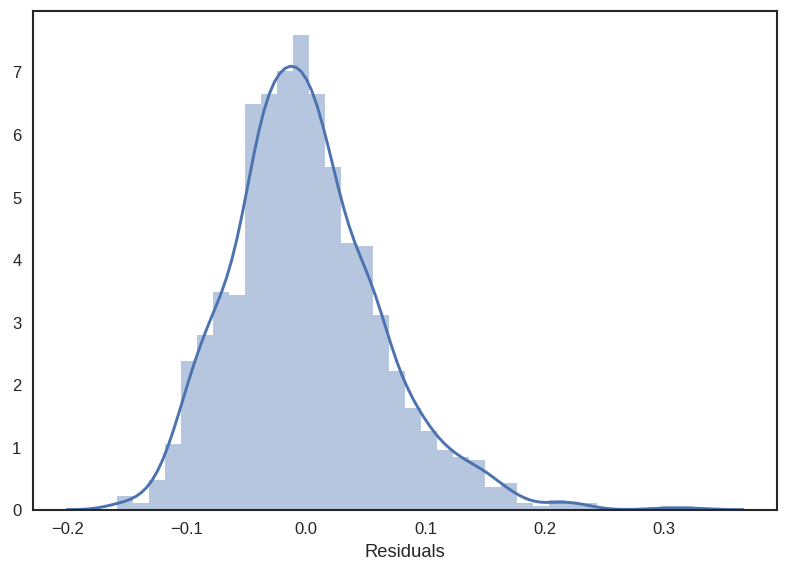

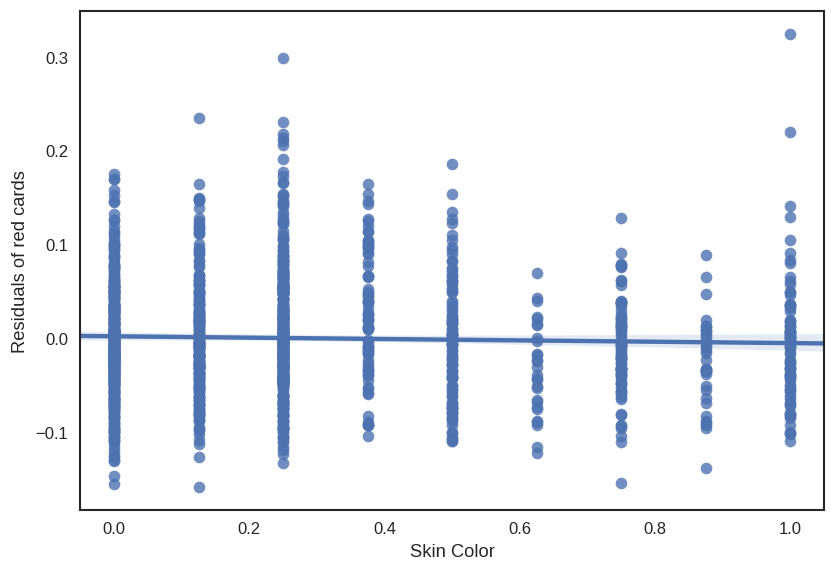

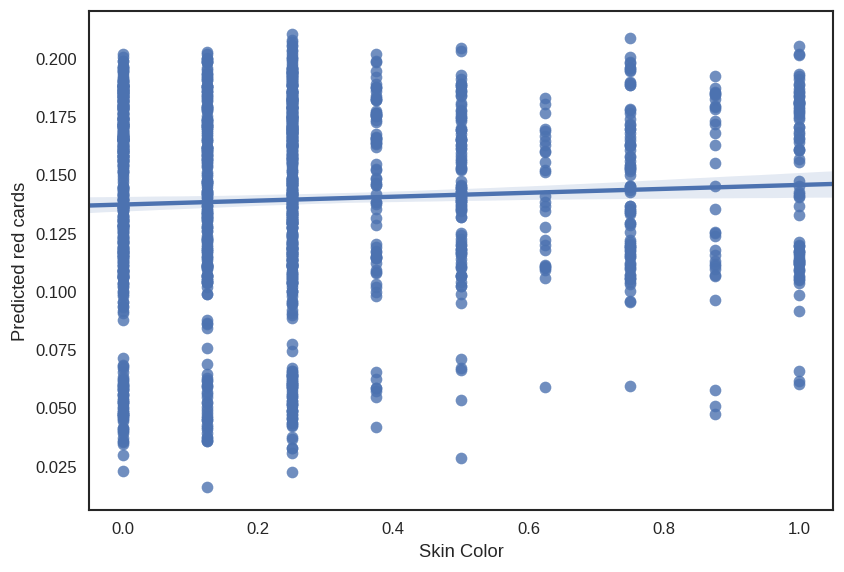

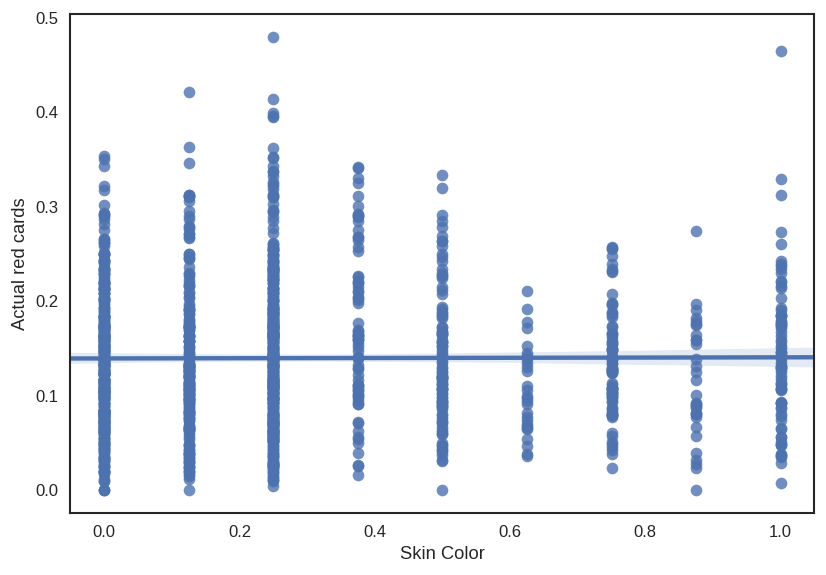

In [74]:
import statsmodels.api as sm
import seaborn as sns

data_encoded = df_agg.copy(deep=True)
data_encoded = data_encoded.loc[:, data_encoded.columns != 'club']
data_encoded = data_encoded.loc[:, data_encoded.columns != 'playerShort']
data_encoded = data_encoded.loc[:, data_encoded.columns != 'weight']
data_encoded = data_encoded.loc[:, data_encoded.columns != 'games']
data_encoded = data_encoded.loc[:, data_encoded.columns != 'meanIAT']
data_encoded = data_encoded.loc[:, data_encoded.columns != 'meanExp']
skin_color = data_encoded['skin_color']
data_encoded = data_encoded.loc[:, data_encoded.columns != 'skin_color']
data_encoded = pd.get_dummies(data_encoded)

target = 'red_cards_per_game'

y = data_encoded[target].values
predictors = data_encoded.loc[:, data_encoded.columns != target].columns.values
X = data_encoded.loc[:, predictors].values

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10)

mod = sm.OLS(y, sm.add_constant(X))

res = mod.fit()

predictors_with_constant = predictors.tolist()
predictors_with_constant.insert(0, 'constant')

print(res.summary(yname=target, xname=predictors_with_constant))

sns.distplot(res.resid)
plt.xlabel('Residuals')
plt.show()

sns.regplot(x=skin_color, y=res.resid)
plt.xlabel('Skin Color')
plt.ylabel('Residuals of red cards')
plt.show()

sns.regplot(x=skin_color, y=res.fittedvalues)
plt.xlabel('Skin Color')
plt.ylabel('Predicted red cards')
plt.show()

sns.regplot(x=skin_color, y=y)
plt.xlabel('Skin Color')
plt.ylabel('Actual red cards')
plt.show()


## Logistic Regression Work

Here we disaggregate the data and do a simple logistic regression



In [ ]:
# start with raw data frame


## Mixed Model work

Here we do a mixed effects model.  



In [75]:
import statsmodels.formula.api as smf

md = smf.mixedlm("red_cards_per_game ~ skin_color", data, groups=data["refNum"])

res = md.fit()

print(res.summary())



/usr/local/lib/python3.6/dist-packages/statsmodels/regression/mixed_linear_model.py:2019: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


             Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: red_cards_per_game
No. Observations: 115457  Method:             REML              
No. Groups:       2893    Scale:              0.0052            
Min. group size:  1       Likelihood:         139347.2105       
Max. group size:  772     Converged:          Yes               
Mean group size:  39.9                                          
------------------------------------------------------------------
               Coef.   Std.Err.     z      P>|z|   [0.025   0.975]
------------------------------------------------------------------
Intercept      0.008      0.000   22.438   0.000    0.007    0.008
skin_color     0.003      0.001    3.411   0.001    0.001    0.004
groups RE      0.000      0.000                                   



In [76]:
np.max(data['red_cards_per_game'])

1.0

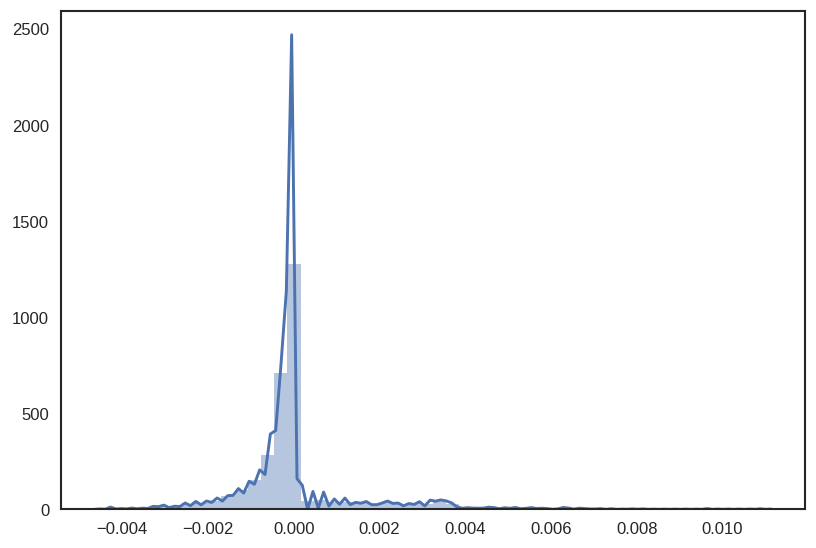

In [77]:
sns.distplot(list(res.random_effects.values()))

In [78]:
import statsmodels.formula.api as smf

md = smf.mixedlm("red_cards_per_game ~ skin_color", data, groups=data["refNum"], re_formula="~skin_color")

res = md.fit()

print(res.summary())

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


KeyboardInterrupt: ignored

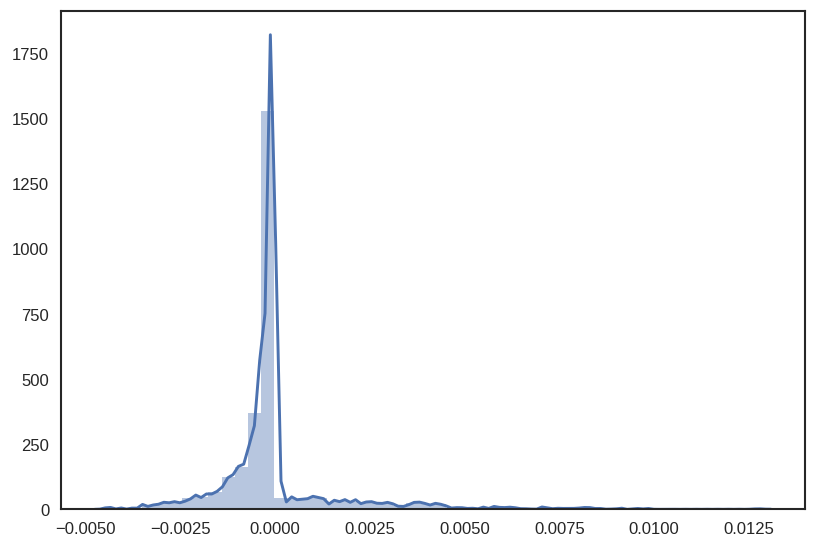

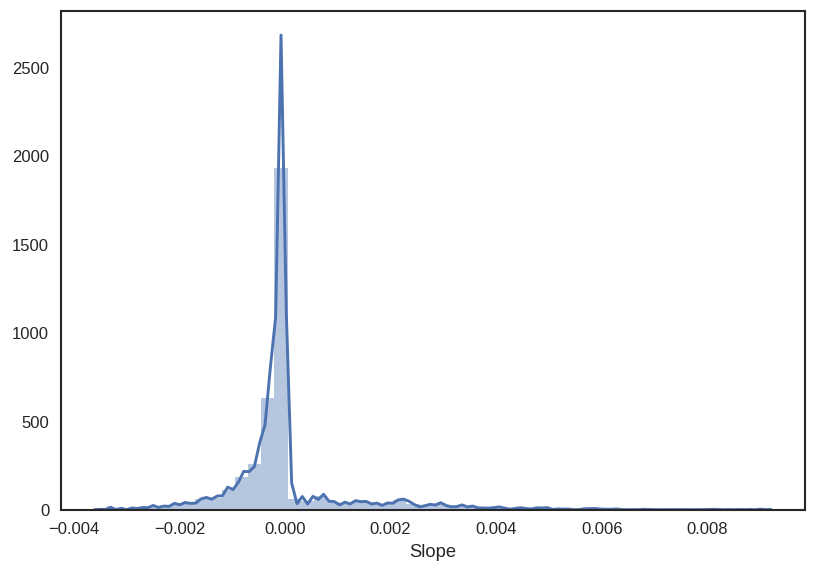

Text(0.5,0,'Intercept')

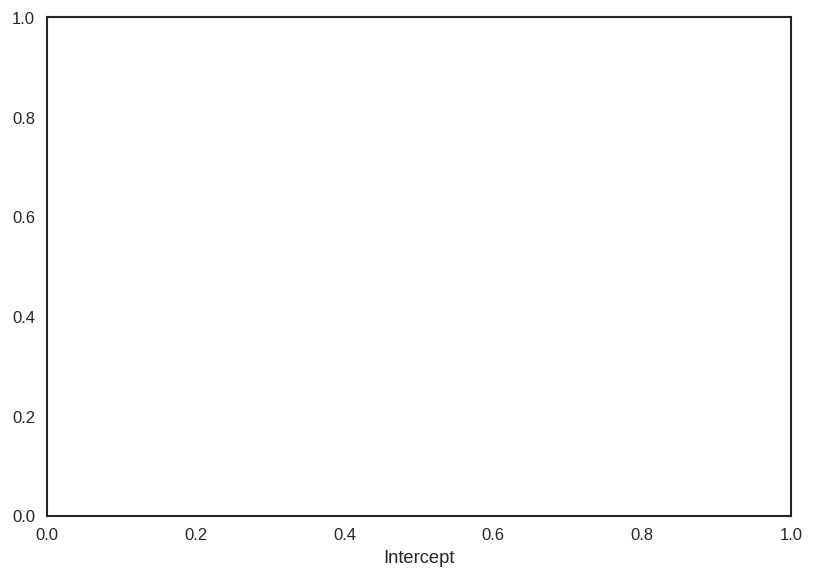

In [367]:
df = pd.DataFrame(res.random_effects)
sns.distplot(df.loc['skin_color',:].values)
plt.xlabel('Slope')
plt.show()

df = pd.DataFrame(res.random_effects)
sns.distplot(df.loc['Intercept',:].values)
plt.xlabel('Intercept')
plt.show()

array([-4.26405524e-05, -2.63314642e-03, -1.95744511e-04, ...,
       -5.28257872e-04, -1.11930317e-04, -7.02175462e-05])